In [2]:
import astropy
import numpy as np
import matplotlib
import scipy

from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter 

In [3]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['text.color'] = 'Black'
plt.rcParams['font.size'] = '14'
plt.rcParams['figure.figsize'] = (9, 6)

In [4]:
file = fits.open('/Users/FRANNYPACK/Downloads/grind!/research/Data/MW_foreground_SMC.fits')
file[0].header

SIMPLE  =                    T  /                                               
BITPIX  =                  -32  /                                               
NAXIS   =                    3  /                                               
NAXIS1  =                 3901  /                                               
NAXIS2  =                 3471  /                                               
NAXIS3  =                   84  /                                               
EXTEND  =                    T  /                                               
BSCALE  =    1.00000000000E+00  /                                               
BZERO   =    0.00000000000E+00  /                                               
BLANK   =                   -1  /                                               
BUNIT   = 'K       '  /                                                         
DATE-OBS= '2019-12-22T06:12:09.7'  /                                            
TELESCOP= 'ASKAP   '  /     

# RELEVANT FUNCTIONS

In [5]:
def v_indx(v_val): # v_val must be in m/s
    return int((v_val - 3.99321598442 * 10 ** 4) / (-9.77198303456 * 10 ** 2))

In [6]:
# does actual work of USM
def process_usm(cc_sum, FWHM = 30.):
    pix_len = file[0].header['CDELT2'] * 60 # ['CDELT2'] = pixel length in deg, multiply by 60 to convert to arcmin
    FWHM30_pix = FWHM / pix_len # want FWHM to be 30 arcmin, so convert from arcmin to pixels
    sigma = FWHM30_pix / (2 * np.sqrt(2 * np.log(2))) # converts from FWHM to sigma, since Gaussian filter specified by sigma
    sum_smooth = gaussian_filter(cc_sum, sigma = sigma)
    sum_USM = cc_sum - sum_smooth
    return sum_USM


In [8]:
# computes unsharp mask over 3 km/s at a time, then adds them up (so as to not wash out the small-scale structure)
def usm_mult(v_indx_min, v_indx_max, maskb = False, amt = 300):
    cur = v_indx_min
    num_iterations = int((v_indx_max - v_indx_min) / 3) # 3 km/s at a time = 3 maps at a time
    tot_sum_USM = np.zeros((3471, 3901))
    
    for i in range(num_iterations + 1):
        if (i == num_iterations): # remainder of 3 that we have to integrate over
            if ((v_indx_max - v_indx_min) % 3 == 0): # nothing left to integrate over - we done!
                tot_sum_USM[np.where(tot_sum_USM < 0.)] = 0.
                return tot_sum_USM
            else:
                cube_chunk = file[0].data[cur:v_indx_max, :, :]
        else: 
            cube_chunk = file[0].data[cur:cur + 3, :, :]
            
        num_v, num_y, num_x = cube_chunk.shape
        cc_sum = np.nansum(cube_chunk, axis = 0) / num_v
        if maskb:
            cc_sum = mask_border(cc_sum, amt = amt)
        tot_sum_USM += process_usm(cc_sum)
        cur += 3
        
    tot_sum_USM[np.where(tot_sum_USM < 0.)] = 0. # at end so negative noise cancels out with positive noise
    return tot_sum_USM

In [9]:
# main function
def usm(v_indx_min, v_indx_max = -1, maskb = False, amt = 300):
    file = fits.open('/Users/FRANNYPACK/Downloads/grind!/research/Data/MW_foreground_SMC.fits') # reset
    
    # specific channel map
    if v_indx_max == -1:
        cc_sum = file[0].data[v_indx_min, :, :]
        sum_USM = process_usm(cc_sum)
        sum_USM[np.where(sum_USM < 0.)] = 0. # at end so negative noise cancels out with positive noise
    
    # over range of channel maps
    else:   
        sum_USM = usm_mult(v_indx_min, v_indx_max, maskb = maskb, amt = amt)
        
    file = fits.open('/Users/FRANNYPACK/Downloads/grind!/research/Data/MW_foreground_SMC.fits') # reset
    return sum_USM

In [10]:
# displays USM 
def show_usm(cd, v = '', vmin = 0, vmax = 0):
    plt.figure(figsize = (20, 12))
    plt.imshow(np.flip(np.abs(cd), axis = 0), cmap = 'magma', vmin = vmin, vmax = vmax)
    if v != '':
        plt.title(str(v) + ' km/s', fontsize = 50)
    plt.colorbar()

# INDIVIDUAL MAPS

In [11]:
im1 = usm(41)

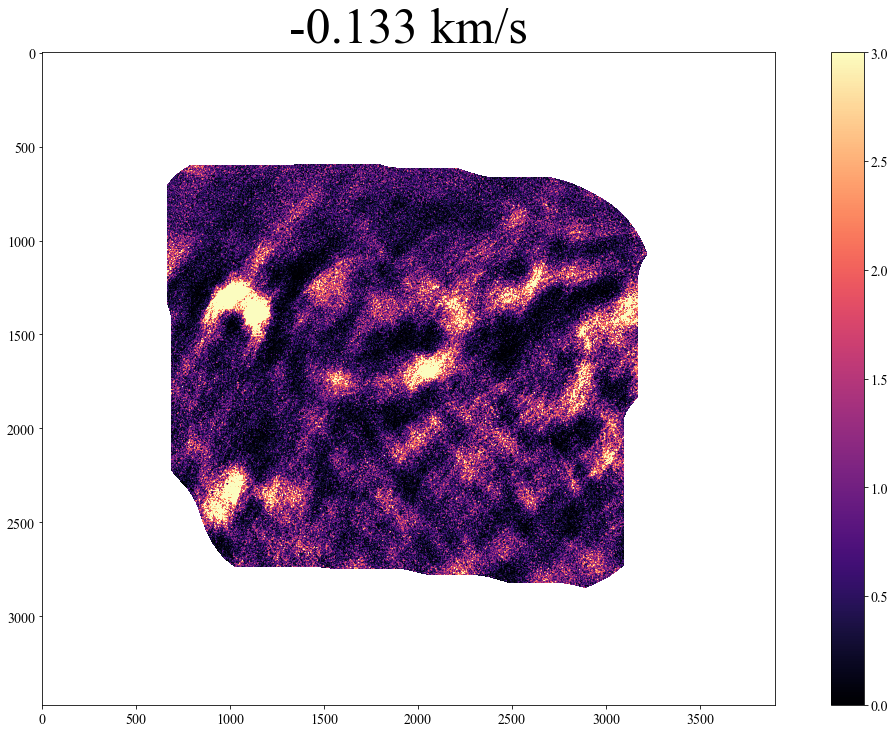

In [12]:
show_usm(im1, v = -0.133, vmax = 3)

In [13]:
im2 = usm(30)

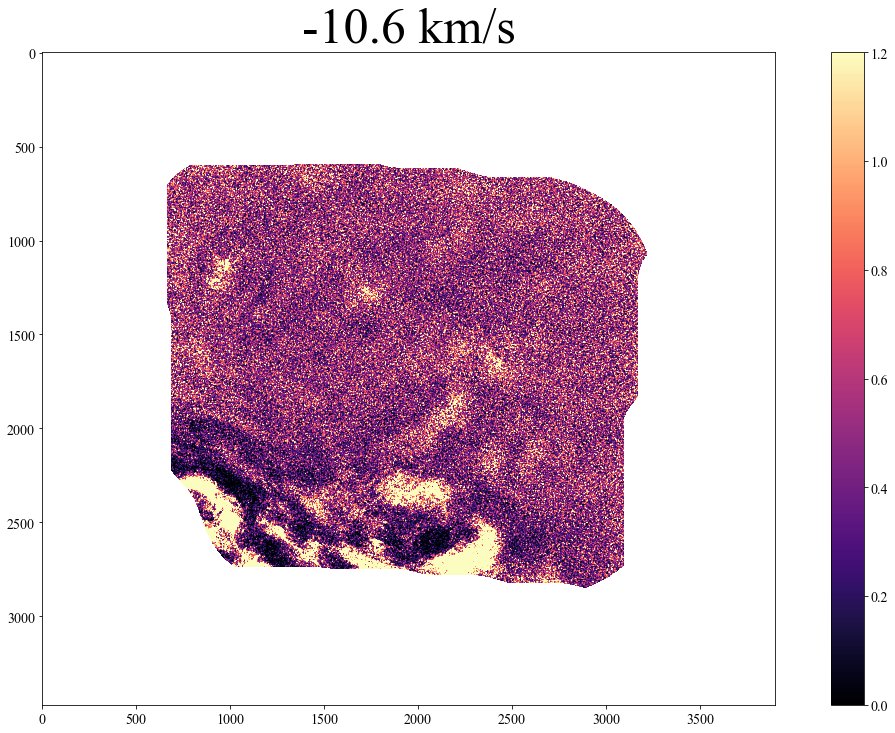

In [18]:
show_usm(im2, v = -10.6, vmax = 1.2)

In [15]:
im3 = usm(46)

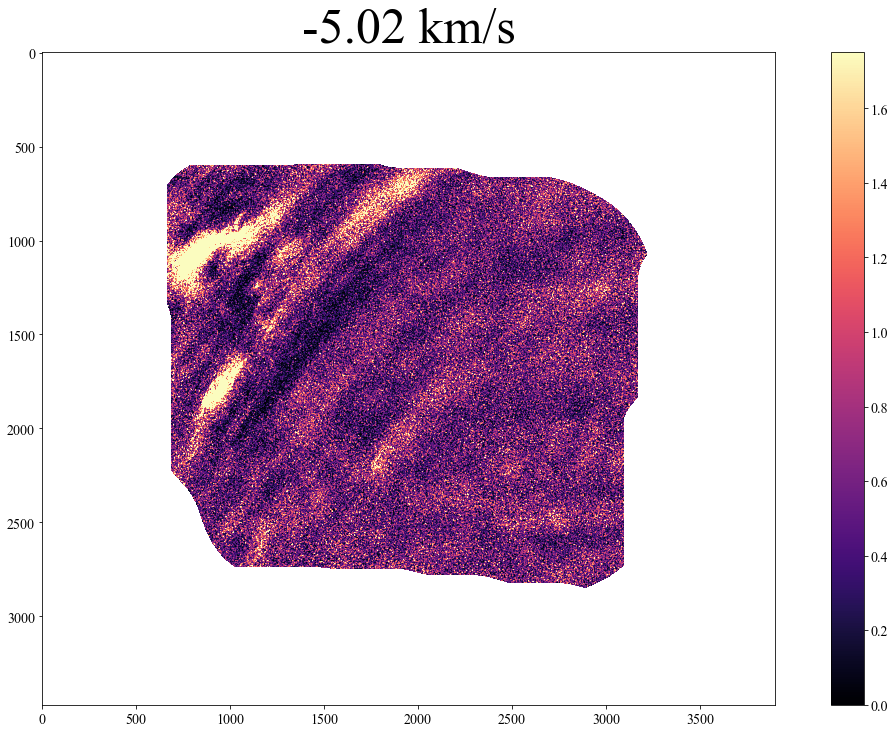

In [16]:
show_usm(im3, v = -5.02, vmax = 1.75)

# INTEGRATING OVER MULTIPLE VELOCITIES

In [19]:
# where most structure lies
most_SS = usm(25, v_indx_max = 50)

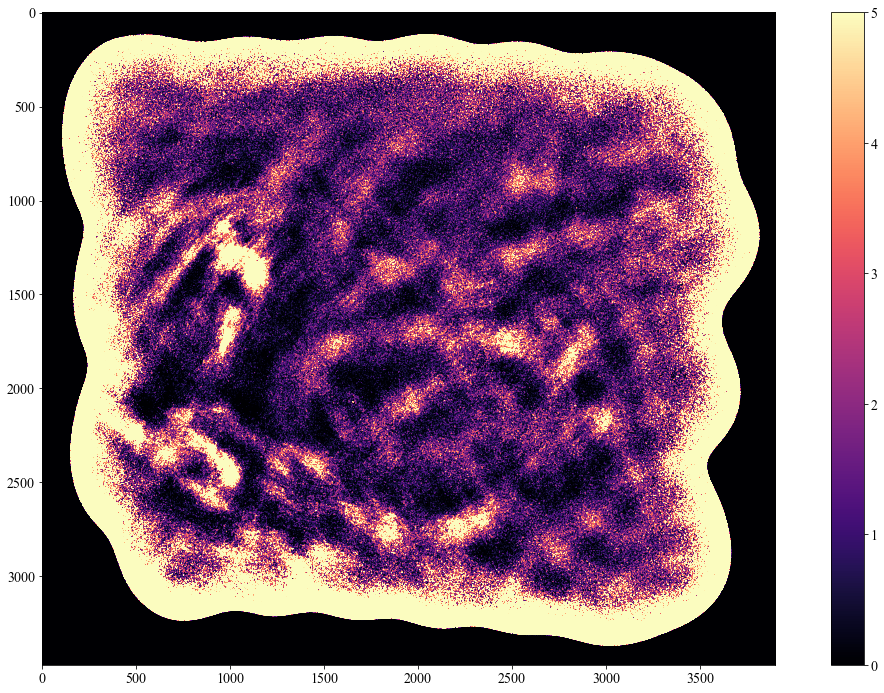

In [20]:
show_usm(most_SS, vmax = 5)

In [21]:
# where structure peaks
peak_SS = usm(35, 45)

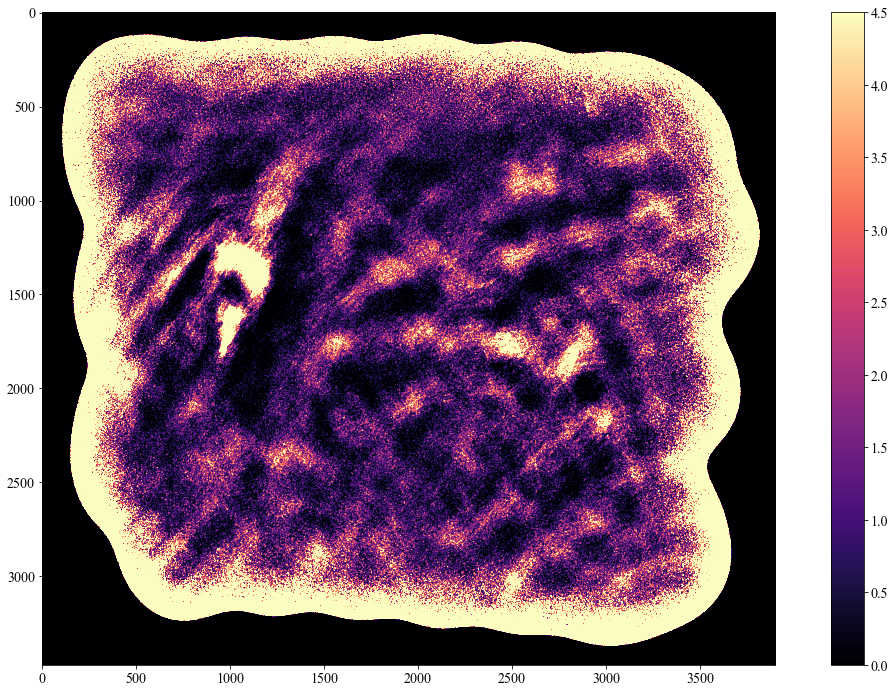

In [26]:
show_usm(peak_SS, vmax = 4.5)

In [23]:
# over entire range of velocities
all_SS = usm(0, 84)

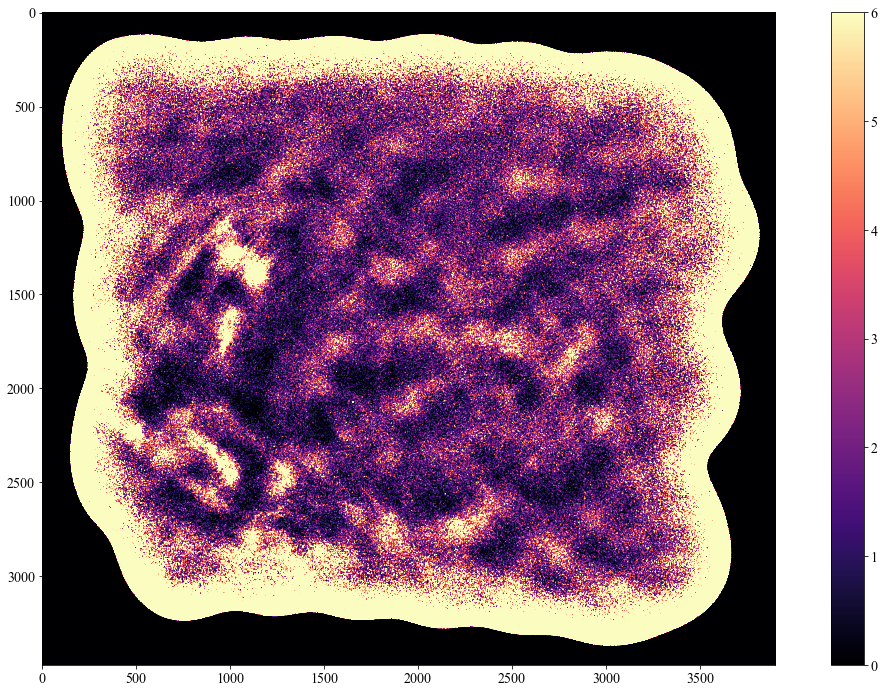

In [25]:
show_usm(all_SS, vmax = 6)

# COMPARING BRIGHTNESS TEMPERATURES

In [11]:
# brightness intensity vs velocity for TOTAL cube (over same range of velocities as RHT cube)
file[0].data[file[0].data == -32786] = np.nan
sum_data = np.nansum(np.nansum(file[0].data[26:61,:,:], axis = 1), axis = 1)

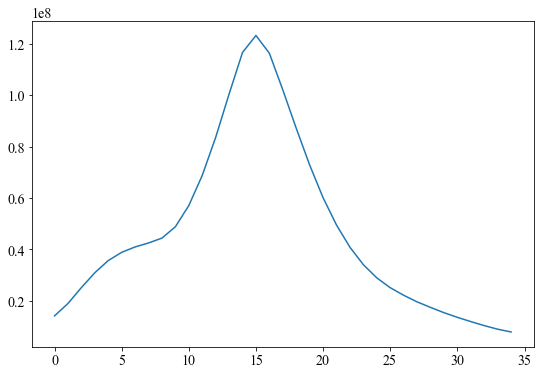

In [12]:
plt.plot(sum_data) 

In [27]:
USM_cube = fits.open('/Users/FRANNYPACK/Downloads/grind!/research/Data/SMC_USM_cube.fits')

In [14]:
# brightness intensity vs velocity for USM cube 
USM_sum_data = np.nansum(np.nansum(USM_cube[0].data, axis = 1), axis = 1)

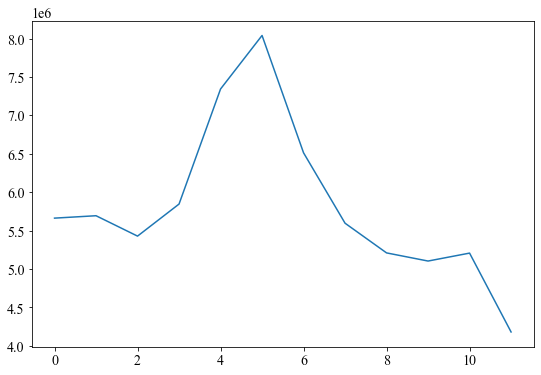

In [15]:
plt.plot(USM_sum_data)